In [1]:
'''
random_forest.py = here we build a random forest model to run over the K-fold CV
  Copyright (c) 2023 Charlie Payne
  Licence: GNU GPLv3
DESCRIPTION
  this notebook builds the optimal random forest model via the OptimalRF class
  it then runs the model for the dataset of your choice
NOTES
  [none]
RESOURCES
  -- https://www.datacamp.com/tutorial/random-forests-classifier-python
CONVENTIONS
  [none]
KNOWN BUGS
  [none]
DESIRED FEATURES
  [none]
'''

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [2]:
class OptimalRF():
    '''
    CLASS: OptimalRF = this finds the optimal random forest model via a grid search method
    '''
    def __init__(self, X_train: np.ndarray, X_test: np.ndarray, y_train: pd.DataFrame, y_test: pd.DataFrame,
                 nest: int, maxd: int, score: str) -> None:
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        self.nest = nest
        self.maxd = maxd
        self.score = score
    
    def find_best_rf(self) -> None:
        '''
        METHOD: find_best_rf = this method builds the RandomizedSearchCV() to find the optimal parameters for the random forest
        '''
        param_dist = {'n_estimators': randint(1, self.nest), 'max_depth': randint(1, self.maxd)}
        
        rf = RandomForestClassifier(class_weight="balanced")
        rand_search = RandomizedSearchCV(rf,
                                         param_distributions=param_dist,
                                         scoring=self.score,
                                         n_iter=15,
                                         cv=5)
        
        rand_search.fit(self.X_train, self.y_train['class'])
        
#         self.best_est = rand_search.best_estimator_
        self.best_params = rand_search.best_params_
        print('Best hyperparameters:', self.best_params)
    
    def train_best_rf(self) -> None:
        '''
        METHOD: train_best_rf = after find_best_rf, we now train the optimal random forest using the optimal parameters
        '''
        self.rf_best = RandomForestClassifier(max_depth=self.best_params['max_depth'], n_estimators=self.best_params['n_estimators'])
        self.rf_best.fit(self.X_train, self.y_train['class'])
    
    def make_prediction(self) -> None:
        '''
        METHOD: make_prediction = now make a prediction on the test data with the optimal random forest model
        '''
        self.y_pred = self.rf_best.predict(self.X_test)
    
    def calc_scores(self) -> None:
        '''
        METHOD: calc_scores = calculate the accuracy, precision, recall, and F1-score
        '''
        self.accuracy = accuracy_score(self.y_test['class'], self.y_pred)
        self.precision = precision_score(self.y_test['class'], self.y_pred)
        self.recall = recall_score(self.y_test['class'], self.y_pred)
        self.f1 = 2*self.precision*self.recall/(self.precision + self.recall)
        
        print("Accuracy =", self.accuracy)
        print("Precision =", self.precision)
        print("Recall =", self.recall)
        print("F1 =", self.f1, '\n')
    
    def print_confusion_matrix(self) -> None:
        '''
        METHOD: print_confusion_matrix = construct the confusion matrix on the test prediction
        '''
        cm = confusion_matrix(self.y_test['class'], self.y_pred)
        ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    
    def run(self) -> None:
        '''
        METHOD: run = run all the methods in order
        '''
        self.find_best_rf()
        self.train_best_rf()
        self.make_prediction()
        self.calc_scores()
        self.print_confusion_matrix()

In [3]:
def control_metrics(y_test: pd.DataFrame) -> [float, float, float, float]:
    '''
    FUNCTION: control_metrics = calculate the metrics assuming we predict only 1's, this acts as a control
          IN: y_test = the dataframe from the input data
    '''
    num_HC = len([val for val in y_test['class'] if val == 0])
    num_PD = len([val for val in y_test['class'] if val == 1])

    # assume predict only 1's, these values should be beaten by the random forest model's average metrics
    control_accuracy = (num_PD + 0)/(num_PD + num_HC + 0 + 0)  # (TP + TN)/(TP + FP + TN + FN)
    control_precision = num_PD/(num_PD + num_HC)  # TP/(TP + FP)
    control_recall = num_PD/(num_PD + 0)  # TP/(TP + FN)
    control_f1 = 2*control_precision*control_recall/(control_precision + control_recall)

    print("Control Accuracy =", control_accuracy)
    print("Control Precision =", control_precision)
    print("Control Recall =", control_recall)
    print("Control F1 =", control_f1)
    
    return control_accuracy, control_precision, control_recall, control_f1

In [20]:
# use this and the next cell to run a single test_train_split or single fold

# front_dir = '../data/split/pure/standard'
front_dir = '../data/split/outrmv/standard'

X_train = np.loadtxt(front_dir + '/X_train.csv', delimiter=',')
X_test = np.loadtxt(front_dir + '/X_test.csv', delimiter=',')
y_train = pd.read_csv(front_dir + '/y_train.csv', index_col=0)
y_test = pd.read_csv(front_dir + '/y_test.csv', index_col=0)

print('---- X_train ----')
print(X_train, '\n')
print('---- X_test ----')
print(X_test, '\n')
print('---- y_train ----')
display(y_train)
print('---- y_test ----')
display(y_test)

---- X_train ----
[[ 1.          0.81975333  0.69853333 ...  4.1948      8.8334
  39.62626667]
 [ 1.          0.82055333  0.78694    ... 45.6855     36.01826667
  80.56003333]
 [ 1.          0.78685333  0.75409333 ...  5.19216667  4.76313333
   6.1184    ]
 ...
 [ 1.          0.80687667  0.64614667 ...  9.72603333  4.98326667
   4.4643    ]
 [ 1.          0.80729333  0.65898667 ...  2.6933      3.6063
  11.27256667]
 [ 1.          0.81699333  0.59052333 ...  2.47883333  4.06243333
   5.46236667]] 

---- X_test ----
[[ 1.          0.7814      0.64865333 ... 12.34726667  7.78446667
   7.63273333]
 [ 1.          0.51546     0.82330333 ...  7.007       8.78573333
   8.0774    ]
 [ 0.          0.83971667  0.60370667 ...  3.50036667  4.48543333
   4.7293    ]
 ...
 [ 0.          0.75876333  0.59048    ...  4.10246667  5.27046667
   3.93283333]
 [ 1.          0.31434667  0.70669    ... 39.6468     27.46403333
  87.40873333]
 [ 1.          0.79603     0.71852667 ... 10.82       28.18306667
  5

,class
174,1
218,1
130,0
18,1
95,1
...,...
116,1
205,1
73,0
199,1


---- y_test ----


,class
165,1
102,1
89,0
228,1
251,0
44,1
15,1
192,0
159,1
45,0


Control Accuracy = 0.7450980392156863
Control Precision = 0.7450980392156863
Control Recall = 1.0
Control F1 = 0.8539325842696629

Best hyperparameters: {'max_depth': 8, 'n_estimators': 84}
Accuracy = 0.7647058823529411
Precision = 0.782608695652174
Recall = 0.9473684210526315
F1 = 0.8571428571428571 

CPU times: user 24.5 s, sys: 222 ms, total: 24.7 s
Wall time: 25.2 s


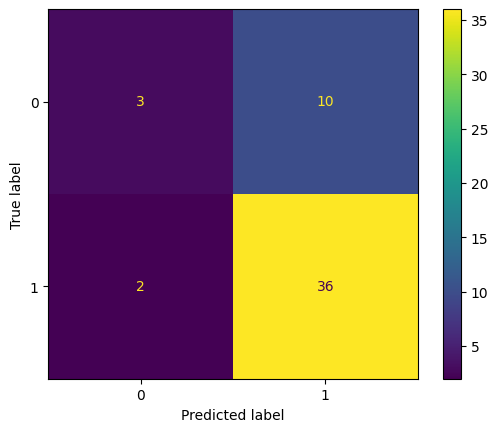

In [21]:
%%time

n_est = 200  # maximum number of trees in the random forest to optimize over
max_d = 20   # maximum depth of said trees to optimize over
metric = 'recall'  # the scoring for RandomizedSearchCV()

control_metrics(y_test)
print('')
orf = OptimalRF(X_train, X_test, y_train, y_test, n_est, max_d, metric)
orf.run()

In [15]:
# run the above cell three times, record the numbers and find the average - there's stochasicity in RandomizedSearchCV()

print("---- metric = 'accuracy' ----")
print("AVG Accuracy =", (0.8333333333333334 + 0.8 + 0.8066666666666666)/3)
print("AVG Precision =", (0.8283582089552238 + 0.7985611510791367 + 0.8043478260869565)/3)
print("AVG Recall =", (0.9823008849557522 + 0.9823008849557522 + 0.9823008849557522)/3)
print("AVG F1 =", (0.8987854251012145 + 0.880952380952381 + 0.8844621513944223 )/3)

print("\n---- metric = 'balanced_accuracy' ----")
print("AVG Accuracy =", (0.82 + 0.8 + 0.8)/3)
print("AVG Precision =", (0.8161764705882353 + 0.7985611510791367 + 0.8029197080291971)/3)
print("AVG Recall =", (0.9823008849557522 + 0.9823008849557522 + 0.9734513274336283)/3)
print("AVG F1 =", (0.891566265060241 + 0.880952380952381 + 0.8800000000000001)/3)

print("\n---- metric = 'recall' ----")
print("AVG Accuracy =", (0.82 + 0.8133333333333334 + 0.82)/3)
print("AVG Precision =", (0.8161764705882353 + 0.8102189781021898 + 0.8161764705882353)/3)
print("AVG Recall =", (0.9823008849557522 + 0.9823008849557522 + 0.9823008849557522)/3)
print("AVG F1 =", (0.891566265060241 + 0.8879999999999999 + 0.891566265060241)/3)

---- metric = 'accuracy' ----
AVG Accuracy = 0.8133333333333334
AVG Precision = 0.8104223953737724
AVG Recall = 0.9823008849557522
AVG F1 = 0.8880666524826726

---- metric = 'balanced_accuracy' ----
AVG Accuracy = 0.8066666666666666
AVG Precision = 0.8058857765655231
AVG Recall = 0.9793510324483776
AVG F1 = 0.8841728820042073

---- metric = 'recall' ----
AVG Accuracy = 0.8177777777777777
AVG Precision = 0.8141906397595534
AVG Recall = 0.9823008849557522
AVG F1 = 0.8903775100401606


In [ ]:
# F- I-- N---